# Classification

In [271]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [272]:
from sklearn.preprocessing import StandardScaler

In [273]:
data = pd.read_csv('../small_business/data/restaurants.csv')
data = data.drop(columns = 'Unnamed: 0')

In [274]:
X = data.drop(columns=['curb_pickup', 'drive_through','rating', 'name', 'address', 'label', 'postal_code', 'no_del_exp', 'municipality', 'review_count'])
y = data['rating']

In [275]:
y.describe()

count    652.000000
mean       4.390644
std        0.363447
min        1.000000
25%        4.200000
50%        4.400000
75%        4.600000
max        5.000000
Name: rating, dtype: float64

In [393]:
y_class=pd.cut(x=y, bins=[0,4.2, 5], 
                        labels=[ "below_average", "above average"])

In [394]:
y_class.value_counts()

above average    482
below_average    170
Name: rating, dtype: int64

(array([  1.,   0.,   0.,   1.,   3.,   8.,  21.,  83., 312., 223.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

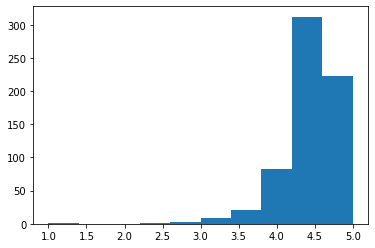

In [395]:
import matplotlib.pyplot as plt
plt.hist(y)

In [396]:
X

,type,price,latitude,longitude,dine_in,takeaway,delivery,neighborhood
0,brunch,2,38.714376,-9.130176,1,1,0,Graça
1,cafe,2,38.706143,-9.161868,1,1,1,Prazeres
2,mediterranean,1,38.717502,-9.120669,1,1,0,Santa Engrácia
3,european,4,38.710140,-9.141088,1,1,0,São Paulo
4,chicken,1,38.707959,-9.158521,1,1,1,Lapa
...,...,...,...,...,...,...,...,...
647,mexican,1,38.712775,-9.126086,1,1,0,Santo Estevão
648,mexican,1,38.716843,-9.141172,1,1,0,Santa Justa
649,mexican,1,38.708392,-9.145909,1,1,0,São Paulo
650,mexican,1,38.710863,-9.144949,1,1,0,Encarnação


In [397]:
X_train, X_test, yc_train, yc_test = train_test_split(X, y_class, test_size=0.30, random_state=3)

In [398]:
price_transformer = SimpleImputer(strategy="most_frequent")
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

preproc_basic = make_column_transformer((num_transformer, ['latitude', 'longitude']),
                                        (price_transformer, ['price']),
                                       (cat_transformer, ['neighborhood', 'type']), remainder='passthrough')

preproc = make_pipeline( preproc_basic)


In [399]:
X_train_t = preproc.fit_transform(X_train)

In [400]:
models= {'KNN':{'model':KNeighborsClassifier(),
               'params':{'n_neighbors': [4, 5,6 ], 'weights':['uniform', 'distance']}}
        }

best = {}      
for key, value in models.items():
    grid_search = GridSearchCV(value['model'], param_grid= value['params'],
                               cv=5, scoring="f1_macro", n_jobs = -1)
    grid_search.fit(X_train_t, yc_train)
    best[key] = {'params':grid_search.best_params_,
                  'score':grid_search.best_score_}

In [401]:
best

{'KNN': {'params': {'n_neighbors': 5, 'weights': 'distance'},
  'score': 0.578549940041954}}

In [402]:
pipe = make_pipeline(preproc)
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['latitude',
                                                                    'longitude']),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['price']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                            

In [403]:
import numpy as np
probs = []
def thresholdsvm(probabilities):
    for i in probabilities[:,0]:
        if i< 0.875:
            probs.append('below_average')  
        else:
            probs.append('above average')

    return np.array(probs)
        

In [404]:
def thresholdknn(probabilities,threshold):
    probsknn = []
    for i in probabilities[:,0]:
        if i< threshold:
            probsknn.append('below_average')  
        else:
            probsknn.append('above average')

    return np.array(probsknn)

In [405]:
probsxgb = []
def thresholdxgb(probabilities):
    for i in probabilities[:,0]:
        if i< 0.9:
            probsxgb.append('below_average')  
        else:
            probsxgb.append('above average')

    return np.array(probsxgb)

/Users/malou/.pyenv/versions/3.8.12/envs/small_business/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
               precision    recall  f1-score   support

above average       0.85      0.43      0.57       141
below_average       0.35      0.80      0.49        55

     accuracy                           0.54       196
    macro avg       0.60      0.62      0.53       196
 weighted avg       0.71      0.54      0.55       196



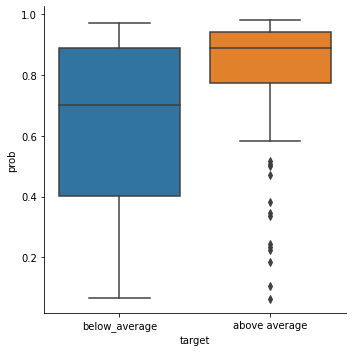

In [406]:
xgb = XGBClassifier(learning_rate = 0.1, max_depth= 20, n_estimators =50)
xgb.fit(pipe.fit_transform(X_train),yc_train)
y_predxgb = xgb.predict(pipe.transform(X_test))
y_probxgb = xgb.predict_proba(pipe.transform(X_test))
res = pd.DataFrame({'prob': y_probxgb[:,0],
                   'target':yc_test})
sns.catplot(data = res, x = 'target', y = 'prob', kind = 'box')
thresholdxgb(y_probxgb)
print(classification_report(yc_test, probsxgb))

               precision    recall  f1-score   support

above average       0.76      0.70      0.73       141
below_average       0.36      0.44      0.39        55

     accuracy                           0.62       196
    macro avg       0.56      0.57      0.56       196
 weighted avg       0.65      0.62      0.63       196



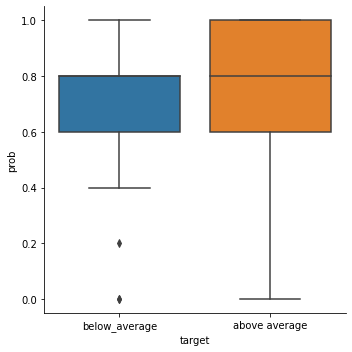

In [410]:
knn = KNeighborsClassifier(n_neighbors = 5,weights= 'uniform' )
knn.fit(pipe.fit_transform(X_train),yc_train)
y_predknn = knn.predict(pipe.transform(X_test))
y_probknn = knn.predict_proba(pipe.transform(X_test))
res = pd.DataFrame({'prob': y_probknn[:,0],
                   'target':yc_test})
sns.catplot(data = res, x = 'target', y = 'prob', kind = 'box')
pred = thresholdknn(y_probknn, 0.8
                   )
print(classification_report(yc_test, pred))

               precision    recall  f1-score   support

above average       0.91      0.69      0.79       170
below_average       0.21      0.54      0.30        26

     accuracy                           0.67       196
    macro avg       0.56      0.62      0.55       196
 weighted avg       0.82      0.67      0.72       196



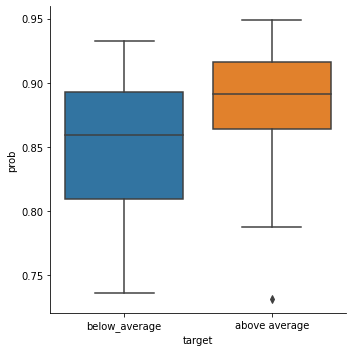

In [362]:
svm = SVC(C= 0.1, class_weight='balanced', probability = True, kernel = 'linear')
svm.fit(pipe.fit_transform(X_train),yc_train)
y_pred = svm.predict(pipe.transform(X_test))
y_prob = svm.predict_proba(pipe.transform(X_test))
res = pd.DataFrame({'prob': y_prob[:,0],
                   'target':yc_test})
sns.catplot(data = res, x = 'target', y = 'prob', kind = 'box')
thresholdsvm(y_prob)
print(classification_report(yc_test,probs))

In [411]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy =', round(accuracy_score(yc_test, y_pred), 2)) # Accuracy

print('Precision =', round(precision_score(yc_test, y_pred, average='weighted'), 2)) # Precision

print('Recall =', round(recall_score(yc_test, y_pred, average='weighted'), 2)) # Recall

print('F1 score =', round(f1_score(yc_test, y_pred, average='weighted'), 2)) # F1 score

Accuracy = 0.63
Precision = 0.65
Recall = 0.63
F1 score = 0.64


In [412]:
y_predknn = knn.predict(pipe.transform(X_test))

In [413]:
predictions = pd.Series(y_predknn)

In [414]:
predictions.value_counts()

above average    174
below_average     22
dtype: int64

## Find nearest neighbours 

In [314]:
knn.kneighbors(X_train_t[5],n_neighbors=10, return_distance=False)

array([[  5,  17, 373, 416, 253, 319, 318,  39, 367, 341]])

In [175]:
def predict_score(data, type_of_food, neighborhood, price):
    #putting the input in the right format
    new_X=pd.DataFrame(columns=['type','price','latitude','longitude', 'dine_in', 'takeaway','delivery', 'drive_through', 'curb_pickup', 'neighborhood'])
    new_row = {'type':type_of_food, 'price': price, 'latitude':'0','longitude':'0', 'takeaway':1,'dine_in':1,'delivery':1, 'drive_through':1, 'curb_pickup':1, 'neighborhood': neighborhood }
    new_X=new_X.append(new_row, ignore_index=True)
    y_predxgb = model.predict(pipe.transform(new_X))
    return y_predxgb 

In [216]:
def restaurant_data():

    data = pd.read_csv('../small_business/data/restaurants.csv')
    data = data.drop(columns = 'Unnamed: 0')
    X = data.drop(columns=['rating','name', 'address', 'label', 'curb_pickup', 'drive_through', 'postal_code', 'no_del_exp', 'municipality', 'review_count'])
    y = data['rating']
    return X, y


In [221]:
def get_pipe(X, y):
    y_class=pd.cut(x=y, bins=[0,4, 5],
                        labels=[ "below_average", "above_average"])
    coordinate_transformer = SimpleImputer(strategy="most_frequent")
    price_transformer = SimpleImputer(strategy="mean")
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    preproc = make_column_transformer((price_transformer, ['price']),
                                       (coordinate_transformer, ['latitude', 'longitude']),
                                        (cat_transformer, ['neighborhood', 'type']), remainder='passthrough')
    pipe = make_pipeline(preproc)
    pipe.fit_transform(X)

In [222]:
X, y = restaurant_data()

In [223]:
get_pipe(X, y)

In [234]:
longitude = pd.Series(X['longitude'].groupby(X['neighborhood']).mean())

In [247]:
all_longitude[]

-9.135643283333332

In [259]:
all_latitude = pd.DataFrame(X['latitude'].groupby(X['neighborhood']).mean())
all_longitude = pd.DataFrame(X['longitude'].groupby(X['neighborhood']).mean())


    

In [270]:
i = 'Socorro'
for neighborhood in all_latitude.index:
    if neighborhood == i:
        print(all_latitude.loc[i].values[0])

   

38.7162168


In [268]:
all_latitude.loc[i].values[0]

38.7162168